In [1]:
import pyslim, tskit
import numpy as np
import msprime
from IPython.display import SVG #for displaying trees in svg format
import matplotlib
import matplotlib.pyplot as plt #plotting
import matplotlib.cm as cm


things to add in this section of the tutorial:
1. short description of what this section is about, what I used, cite slendr tutorial
- "slendr is an R package for simulating spatially-explicit genomic data."
- the package is currently under development
- we can use SLiM to create a .trees file of this spatially-explicit genomic data.
- For simplicity, we will use the spatial simulation from "Introduction and basic tutorial" 
    - extra comments have been added for clarification
    - please refer to the actual tutorial to understand certain functions and visualize the plots, as the code below is condensed for the purposes of this tutorial.
- https://bodkan.net/slendr/index.html for more details and installation instructions.

In [ ]:
"""#SLENDR SIMULATION

#intro slendr
library(slendr)
map <- world(
  xrange = c(-15, 60), # min-max longitude
  yrange = c(20, 65),  # min-max latitude
  crs = "EPSG:3035"    # real projected CRS used internally
)
africa <- region(
  "Africa", map,
  polygon = list(c(-18, 20), c(40, 20), c(30, 33),
                 c(20, 32), c(10, 35), c(-8, 35))
)
europe <- region(
  "Europe", map,
  polygon = list(
    c(-8, 35), c(-5, 36), c(10, 38), c(20, 35), c(25, 35),
    c(33, 45), c(20, 58), c(-5, 60), c(-15, 50)
  )
)
anatolia <- region(
  "Anatolia", map,
  polygon = list(c(28, 35), c(40, 35), c(42, 40),
                 c(30, 43), c(27, 40), c(25, 38))
)
afr <- population(
  "AFR", parent = "ancestor", time = 52000, N = 3000,
  map = map, polygon = africa
)

ooa <- population(
  "OOA", parent = afr, time = 51000, N = 500, remove = 25000,
  center = c(33, 30), radius = 400e3
)

ooa <- ooa %>% move(
  trajectory = list(c(40, 30), c(50, 30), c(60, 40)),
  start = 50000, end = 40000
)

ehg <- population(
  "EHG", parent = ooa, time = 28000, N = 1000, remove = 6000,
  polygon = list(
    c(26, 55), c(38, 53), c(48, 53), c(60, 53),
    c(60, 60), c(48, 63), c(38, 63), c(26, 60))
)

eur <- population( # European population
  name = "EUR", parent = ehg, time = 25000, N = 2000,
  polygon = europe
)

ana <- population( # Anatolian farmers
  name = "ANA", time = 28000, N = 3000, parent = ooa, remove = 4000,
  center = c(34, 38), radius = 500e3, polygon = anatolia
) %>%
  expand( # expand the range by 2.500 km
    by = 2500e3, start = 10000, end = 7000,
    polygon = join(europe, anatolia)
  )
yam <- population( # Yamnaya steppe population
  name = "YAM", time = 7000, N = 500, parent = ehg, remove = 2500,
  polygon = list(c(26, 50), c(38, 49), c(48, 50),
                 c(48, 56), c(38, 59), c(26, 56))
)

yam <- yam %>%
  move(
    trajectory = c(15, 50),
    start = 5000, end = 3000, snapshots = 8
  )

gf <- list(
  geneflow(from = ana, to = yam, rate = 0.5, start = 6500, end = 6400, overlap = FALSE),
  geneflow(from = ana, to = eur, rate = 0.5, start = 8000, end = 6000),
  geneflow(from = yam, to = eur, rate = 0.75, start = 4000, end = 3000)
)

model <- compile(
  populations = list(afr, ooa, ehg, eur, ana, yam), # populations defined above
  geneflow = gf, # geneflow events defined above
  generation_time = 30,
  resolution = 10e3, # resolution in meters per pixel
  competition_dist = 130e3, mate_dist = 100e3, # spatial interaction in SLiM
  dispersal_dist = 70e3, # how far will offspring end up from their parents
  dir = file.path(tempdir(), "slendr"),  overwrite = TRUE
)

#try reading files in our model
list.files(file.path(tempdir(), "slendr"), pattern = "*.png")

#use our model to see the plot
plot_graph(model)

#do some sampling
afr_sample <- sampling(model, times=c(0,51999), list(afr, 3000))
ooa_samples <- sampling(model, times=c(51000, 40000), list(ooa, 500))
ehg_samples <- sampling(model, times=27000, list(ehg, 1000))
eur_samples <- sampling(model, times=24000, list(eur, 2000))
ana_samples <- sampling(model, times=c(27000,7000), list(ana, 3000))
yam_samples <- sampling(model, times=c(6500, 4000), list(yam, 500))


slim(
  model,
  seq_length = 1, recomb_rate = 0, # simulate only a single locus
  ts_recording = TRUE,
  save_locations = TRUE, # save the location of everyone who ever lived
  track_ancestry = 1,
  sampling = rbind(afr_sample, ooa_samples, ehg_samples, eur_samples, ana_samples, yam_samples),
  method = "batch", # change to "gui" to execute the model in SLiMgui
  seed = 314159
)

"""

#### IMPORTANT NOTE ON {OUTPUT} FOLDER:

The output folder "tutorial-model" contains all of our files (map images, model data, .slim file, .trees file) but may be difficult to find. Try:
1. change method to "gui" and open in SLiMgui to see the code
2. constants and parameters will refer to a folder (e.g., defineConstant("MODEL_DIR", "/var/folders/t2/8rnzwjmd1lv2d3x5s0h8t4hr0000gn/T//Rtmpp0EfcK/tutorial-model"); this is our folder of interest
3. press COMMAND SHIFT G and type in the entire folder name 
4. If step 3 does not work, type the first few parts (e.g., just /var/folders/) and keep clicking on the folder names that match the subsequent parts of the directory. 

4. display trees (simplified - unary, + unary, recapitated for coalescence to a single ancestor

5. do parent child plot, maybe add map backgrounf

In [2]:
#let's look at our resulting tree sequences, using the same code from 1. load and simplify tree sequence to a sample
ts = pyslim.load("output_ts.trees")
np.random.seed(314159); n = 5; sampled_nodes = np.random.choice(ts.samples(), 5, replace=False)
sts = ts.simplify(sampled_nodes, keep_unary=True) 

In [3]:
sts

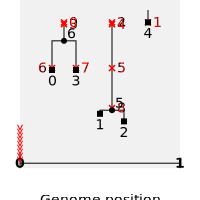

In [4]:
#let's look at our tree!
SVG(sts.simplify(keep_unary=False).draw_svg())

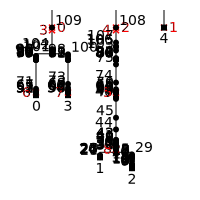

In [5]:
utree = sts.at_index(0) #in this case we only have one tree to work with
SVG(utree.draw_svg()) #displaying the tree, retaining unary nodes

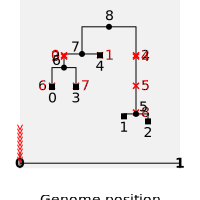

In [6]:
#As you can see, the tree does not coalesce to one common ancestor. We can recapitate the tree:
rts = sts.recapitate(recombination_rate = 1e-8, Ne=200, random_seed=5)
SVG(rts.simplify(keep_unary=False).draw_svg())

In [7]:
for t in np.unique(ts.individual_times):
    print(f"There are {np.sum(ts.individual_times == t)} individuals from time {t}.")

There are 5000 individuals from time 0.0.
There are 2260 individuals from time 1.0.
There are 1242 individuals from time 2.0.
There are 750 individuals from time 3.0.
There are 541 individuals from time 4.0.
There are 392 individuals from time 5.0.
There are 289 individuals from time 6.0.
There are 251 individuals from time 7.0.
There are 197 individuals from time 8.0.
There are 138 individuals from time 9.0.
There are 137 individuals from time 10.0.
There are 111 individuals from time 11.0.
There are 92 individuals from time 12.0.
There are 72 individuals from time 13.0.
There are 90 individuals from time 14.0.
There are 67 individuals from time 15.0.
There are 52 individuals from time 16.0.
There are 58 individuals from time 17.0.
There are 43 individuals from time 18.0.
There are 50 individuals from time 19.0.
There are 39 individuals from time 20.0.
There are 33 individuals from time 21.0.
There are 37 individuals from time 22.0.
There are 28 individuals from time 23.0.
There are 3

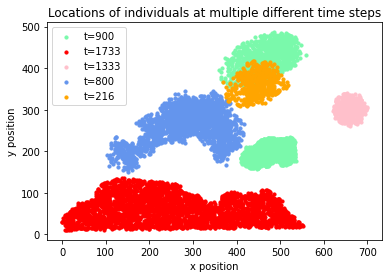

In [15]:
figure2 = plt.figure()

times = [900, 1733, 1333, 800, 216] #create a list of the times we want to plot (we can do as many as we want)
colors = ['xkcd:seafoam green','red', 'pink', 'cornflowerblue', 'orange'] #colors that match the times above

for time, color in zip(times, colors): 
    alive = ts.individuals_alive_at(time)
    where = ts.individual_locations[alive] 
    x = where[:,0] 
    y = where[:,1] 
    plt.scatter(x, y, label= 't=%d' %time, color=color, s=10) #input defined indices
    #the label uses whatever times we define in our list.   
#plt.xlim(0, 900) #Set axes limits to match the scale of the upcoming graph (for better comparison):
#plt.ylim(0, 500)
#Finally, some plotting formalities:
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Locations of individuals at multiple different time steps')
plt.legend() #legend for the labels we created above
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

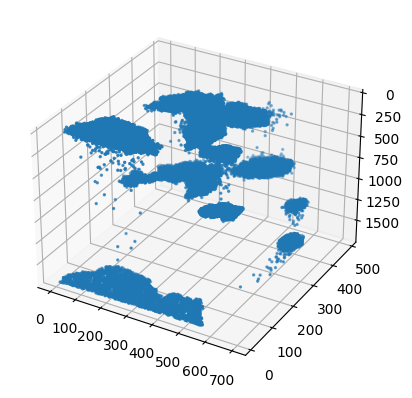

In [17]:
%matplotlib widget
def positions(ts):
    #First, we set up the plot using matplotlib.
    fig = plt.figure()
    threed = fig.add_subplot(projection='3d')

    #We need to create lists in which we will hold the x- and y-coordinates of individuals & the time they were born.
    x, y, t = [], [], []
    
    #Now, we iterate over the individuals in the tree sequence and get their positions & birthdates.
    for ind in ts.individuals():
        #The location attribute of the individual class is an array of the coordinates where the individual is located.
        x_pos = ind.location[0]
        y_pos = ind.location[1]
        time = ind.time
        #Now, we append these values to the lists we created.
        x.append(x_pos)
        y.append(y_pos)
        t.append(time)
    #Time to put it on the plot! First, let's set the z-axis to include all of the generational numbers in our simulation.
    #Because tree sequences count generations backwards, we put the axis in reverse so the final gen is on the top.
    threed.set_zlim([1733,0])
    #So that we can see our data, let's set the size of the points to 2.0. The default size is 10.0.
    threed.scatter3D(x, y, t, s=2.0)

#Let's give our function a go with the simplified tree sequence now:
positions(ts)
#With the %matplotlib widget feature at the very beginning of the code, we can rotate our graph
# & see precisely how individuals are positioned in each generation.